In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, json
import time
from scipy.stats import linregress

# Import API key
#from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Input File (CSV)
input_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
clean_city_data = pd.read_csv(input_data_file)

In [3]:
clean_city_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1321 non-null   int64  
 1   City         1321 non-null   object 
 2   Latitude     1321 non-null   float64
 3   Longitude    1321 non-null   float64
 4   Max Temp     1321 non-null   float64
 5   Wind Speed   1321 non-null   float64
 6   Cloudiness   1321 non-null   float64
 7   Description  1321 non-null   object 
 8   Humidity     1321 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 93.0+ KB


In [4]:
clean_city_data['Augmented Longitude']=clean_city_data['Longitude']+0.0001*clean_city_data['Latitude']
clean_city_data.sort_values("Augmented Longitude", inplace = True)
clean_city_data.drop_duplicates(subset ="Augmented Longitude",keep = False, inplace = True)
clean_city_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 361 to 976
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1319 non-null   int64  
 1   City                 1319 non-null   object 
 2   Latitude             1319 non-null   float64
 3   Longitude            1319 non-null   float64
 4   Max Temp             1319 non-null   float64
 5   Wind Speed           1319 non-null   float64
 6   Cloudiness           1319 non-null   float64
 7   Description          1319 non-null   object 
 8   Humidity             1319 non-null   float64
 9   Augmented Longitude  1319 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 113.4+ KB


In [17]:
parsed_data = clean_city_data[clean_city_data['Max Temp']>(70-32.0)*5.0/9.0+273.15]
parsed_data = parsed_data[parsed_data['Max Temp']<(80-32.0)*5.0/9.0+273.15]
parsed_data = parsed_data[parsed_data['Wind Speed']<10]
parsed_data = parsed_data[parsed_data['Cloudiness']<10]

parsed_data

,Unnamed: 0,City,Latitude,Longitude,Max Temp,Wind Speed,Cloudiness,Description,Humidity,Augmented Longitude
1164,1164,nanakuli,21.3906,-158.1547,295.15,2.06,1.0,clear sky,73.0,-158.152561
134,134,makakilo city,21.3469,-158.0858,296.15,2.06,1.0,clear sky,73.0,-158.083665
1087,1087,clovis,36.8252,-119.7029,297.59,4.63,1.0,clear sky,27.0,-119.699217
522,522,porterville,36.0652,-119.0168,297.04,3.09,1.0,clear sky,43.0,-119.013193
215,215,saint george,37.1041,-113.5841,298.15,1.54,1.0,clear sky,18.0,-113.580390
229,229,chino valley,34.7575,-112.4538,297.59,1.54,1.0,clear sky,18.0,-112.450324
1308,1308,gallup,35.5281,-108.7426,294.82,3.09,1.0,clear sky,11.0,-108.739047
950,950,bucerias,20.7500,-105.3333,299.15,1.03,1.0,clear sky,65.0,-105.331225
292,292,ixtapa,20.7000,-105.2000,299.15,1.03,1.0,clear sky,65.0,-105.197930
598,598,jalpa,21.6333,-102.9667,295.15,2.06,1.0,clear sky,43.0,-102.964537


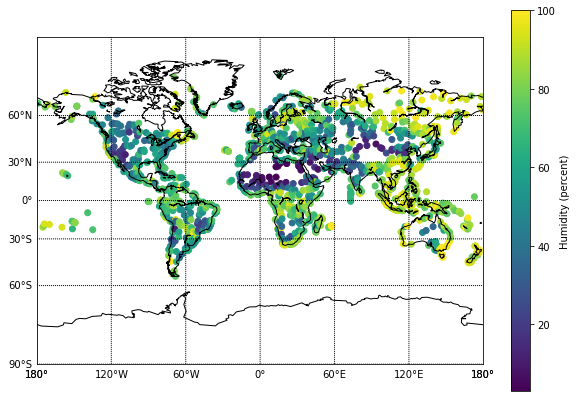

In [18]:
from mpl_toolkits.basemap import Basemap

plt.subplots(figsize=(10, 7))

map = Basemap(projection='mill',lon_0=0)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='coral',lake_color='aqua')
#map.scatter(clean_city_data['Longitude'], clean_city_data['Latitude'], latlon=True,
#          c=clean_city_data['Max Temp'],
#          cmap='Blues', alpha=0.5)

map.scatter(clean_city_data['Longitude'], clean_city_data['Latitude'], latlon=True, 
            c=clean_city_data['Humidity'])

plt.colorbar(label=r'Humidity (percent)')

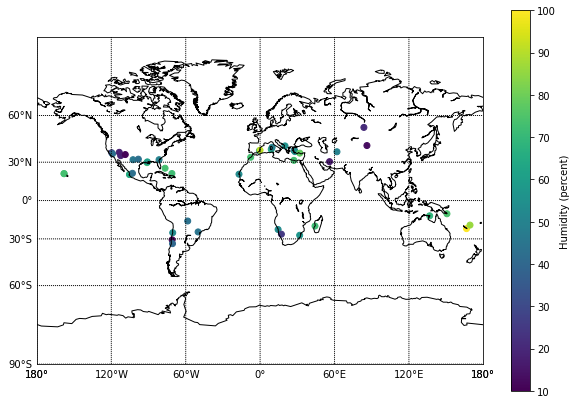

In [19]:
from mpl_toolkits.basemap import Basemap

plt.subplots(figsize=(10, 7))

map = Basemap(projection='mill',lon_0=0)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='coral',lake_color='aqua')
#map.scatter(clean_city_data['Longitude'], clean_city_data['Latitude'], latlon=True,
#          c=clean_city_data['Max Temp'],
#          cmap='Blues', alpha=0.5)

map.scatter(parsed_data['Longitude'], parsed_data['Latitude'], latlon=True, 
            c=parsed_data['Humidity'])

plt.colorbar(label=r'Humidity (percent)')